# Goal

* map-reduce langgraph

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field


In [6]:
model = ChatOpenAI(model="gpt-4o-mini")

In [33]:
# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 4 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
rating_prompt = """Generate rating from 1 (bad) to 10 (great) for the following joke: {joke}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""

In [34]:
class Subjects(BaseModel):
    subjects: list[str]

class Joke(BaseModel):
    joke: str

class Rating(BaseModel):
    rating: int

class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke, starting with 0", ge=0)


In [45]:
# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    ratings: Annotated[list, operator.add]
    best_selected_joke: str

# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str
    joke: str
    rating: int

In [46]:
# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"joke": response.joke}

# Here we generate a review of the joke
def generate_rating(state: JokeState):
    prompt = rating_prompt.format(joke=state["joke"])
    response = model.with_structured_output(Rating).invoke(prompt)
    return {"ratings": [response.rating], "jokes": [state["joke"]]}

# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

In [47]:
# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)

# nodes
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("generate_rating", generate_rating)
graph.add_node("best_joke", best_joke)

# edges
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "generate_rating")
graph.add_edge("generate_rating", "best_joke")
#graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# compile the graph
app = graph.compile()

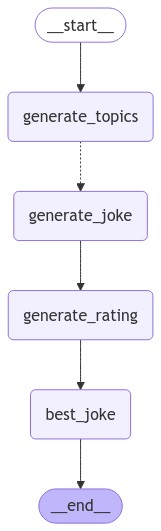

In [48]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [50]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}, config={"max_concurrency" : 3}):
    print(s)

{'generate_topics': {'subjects': ['lion', 'elephant', 'dolphin', 'giraffe']}}
{'generate_joke': {'joke': 'Why did the lion eat the tightrope walker? Because he wanted a well-balanced meal!'}}
{'generate_joke': {'joke': "Why do elephants never use computers? Because they're afraid of the mouse!"}}
{'generate_joke': {'joke': 'Why did the dolphin bring a towel to the party? Because it wanted to have a whale of a time!'}}
{'generate_joke': {'joke': "Why don't giraffes like fast food? Because they can't catch it!"}}


InvalidUpdateError: At key 'joke': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE